In [16]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os
from sklearn.metrics import mean_squared_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of seaborn.axisgrid failed: Traceback (most recent call last):
  File "/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/home/toneyan/.conda/envs/tf/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/seaborn/axisgrid.py", line 12, in <module>
    from ._core import VectorPlotter, variable_type, categorical_order
ImportError: cannot import name 'VectorPlotter' from 'seaborn._core' (/home/toneyan/.co

In [17]:
cell_lines = ['PC-3', 'GM12878', 'K562']
model_name = 'enformer'

_, cre_tiles = utils.set_tile_range(custom_model.Enformer().seq_length, 5000)

In [18]:
result_summary = {}
for cell_line in cell_lines:
    cell_line_res_paths = glob.glob(f'../results/higher_order_test_max/{model_name}/{cell_line}/*pickle')
    context_df = pd.read_csv(f'../results/context_dependence_test/{model_name}/{cell_line}_context.csv')
    traces = {k:[] for k in context_df['context'].unique()}
    hypothetical_traces = {k:[] for k in context_df['context'].unique()}
    for _, row in context_df.iterrows():
        res_path = f"../results/higher_order_test_max/{model_name}/{cell_line}/{row['path'].split('/')[-1]}"
        res = utils.read_pickle(res_path)

        traces[row['context']].append([res[i]['initial_pred']/res[0]['initial_pred'] for i in res.keys()])
        ####hypothetical additive model
        greedy_search_order = [np.argwhere(np.array(cre_tiles) == res[i]['selected_tile'])[0][0] for i in res.keys()]
        mutant_predictions_first_iter = res[0]['preds'].mean(axis=-1)
        wt = res[0]['initial_pred']
        effect_sizes_first_iter = mutant_predictions_first_iter - wt
        sorted_effect_first_iter = effect_sizes_first_iter[greedy_search_order]
        sum_of_effects = np.cumsum(sorted_effect_first_iter) 
        hypothetical_trace = wt + sum_of_effects
        hypothetical_trace = np.concatenate([[wt], hypothetical_trace]) / wt
        
        hypothetical_traces[row['context']].append(hypothetical_trace[:-1])
    result_summary[cell_line] = {'greedy search': traces, 'hypothetical additive': hypothetical_traces}

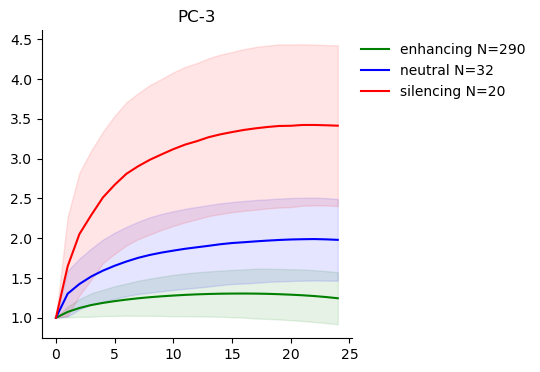

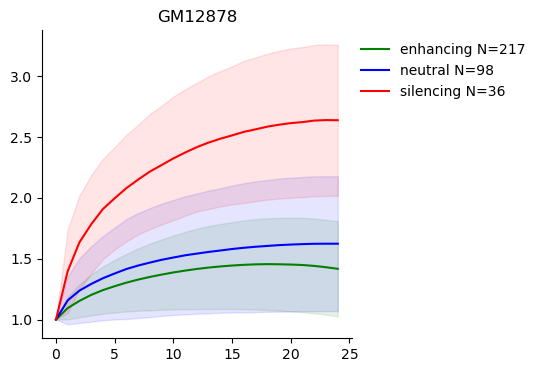

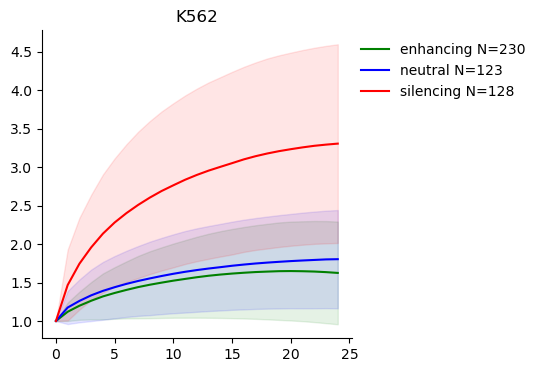

In [19]:
color_map = {'enhancing': 'g', 'neutral':'b', 'silencing':'r'}
for cell_line in cell_lines:


    fig, ax = plt.subplots(1, 1, figsize=[4,4])
    
    for context, data in result_summary[cell_line]['greedy search'].items():
        data = np.array(data)
        
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        color = color_map[context]
        ax.plot(mean, c=color, alpha=1, label=f'{context} N={data.shape[0]}')
        ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)

    plt.legend(frameon=False, bbox_to_anchor=[1.6,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)
    plt.show()

In [20]:
def plot_line_with_std(data, color, label=''):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    ax.plot(mean,alpha=1, label=label, color=color)
    ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)

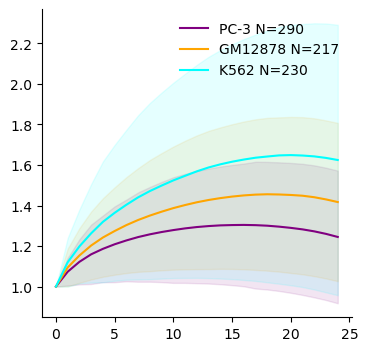

In [21]:
fig, ax = plt.subplots(1, 1, figsize=[4,4])
colors = ['purple', 'orange', 'cyan']
for i, cell_line in enumerate(cell_lines):
    context = 'enhancing'
    data = result_summary[cell_line]['greedy search'][context]
    data = np.array(data)
    plot_line_with_std(data, colors[i], f'{cell_line} N={data.shape[0]}')
    plt.legend(frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


# Hypothetical additive model

/tmp/ipykernel_1003106/2048701201.py:31: RuntimeWarning: Mean of empty slice.
  t_mean = t.mean(axis=0)
/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_1003106/2048701201.py:31: RuntimeWarning: Mean of empty slice.
  t_mean = t.mean(axis=0)
/home/toneyan/.conda/envs/tf/lib/python3.9/site-packages/numpy/cor

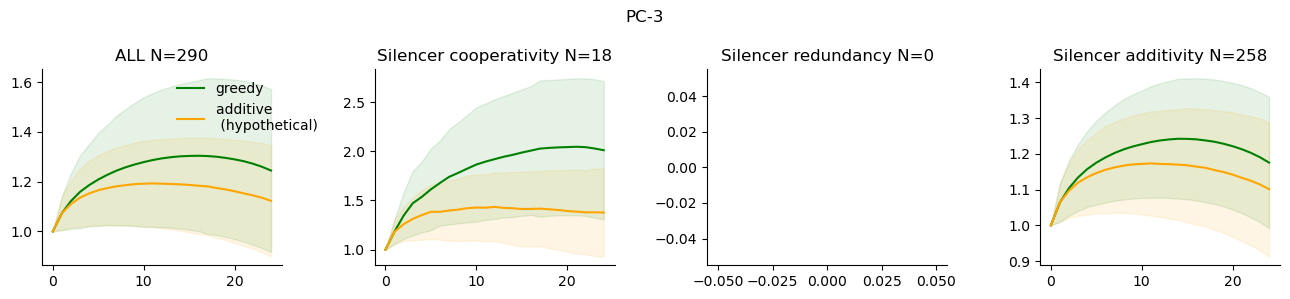

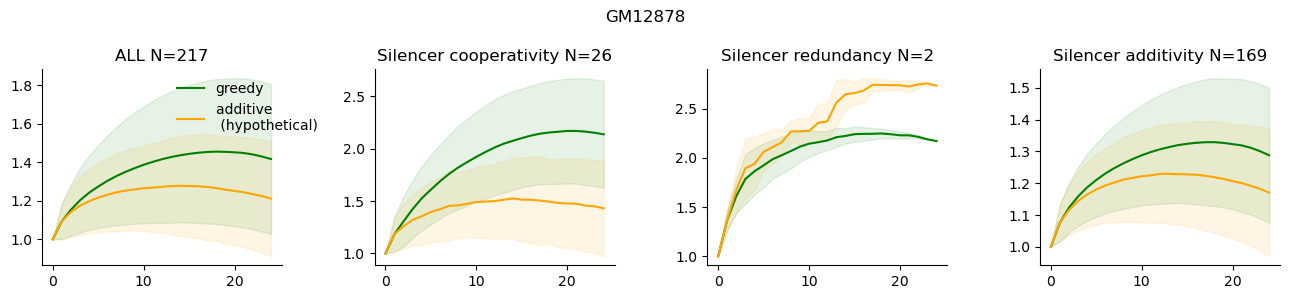

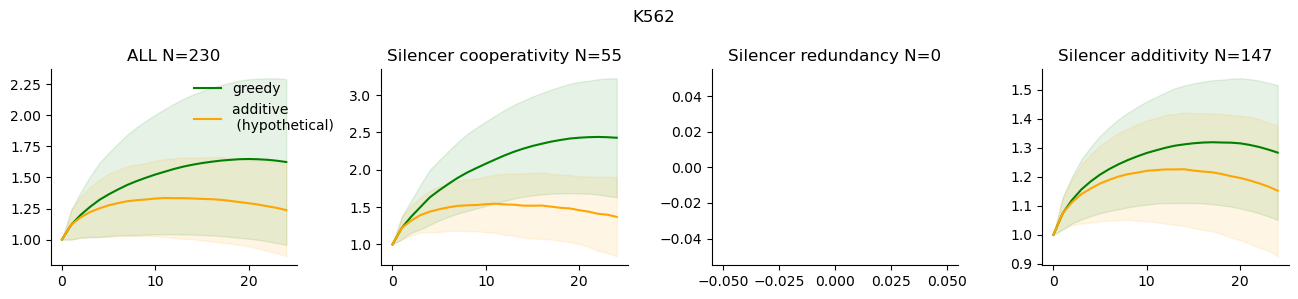

In [22]:
for cell in cell_lines:

    sign = []
    MSE = []
    enhancing_greedy = np.array(result_summary[cell]['greedy search']['enhancing'])
    enhancing_hyp = np.array(result_summary[cell]['hypothetical additive']['enhancing'])
    for trace, hypothetical_trace in zip(enhancing_greedy, enhancing_hyp):
        MSE.append(mean_squared_error(trace, hypothetical_trace))
        sign.append(np.mean(trace) - np.mean(hypothetical_trace))
    MSE = np.array(MSE) 

    colors = ['green', 'orange']
    labels = ['cooperative', 'additive']
    titles = ['ALL', 'Silencer cooperativity', 'Silencer redundancy', 'Silencer additivity']
    # i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
    
    pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.1]
    neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.1]
    zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.05]
    all_points = np.arange(len(sign))

    fig, axes = plt.subplots(1, len(titles), figsize=[13, 3])
    curve_labels = ['greedy', 'additive \n (hypothetical)']
    
    for p, points in enumerate([all_points, pos_points, neg_points, zero_points]):
        ax = axes[p]
        ax.set_title(f'{titles[p]} N={len(points)}')
        trace_set, hypothetical_trace_set = enhancing_greedy[points], enhancing_hyp[points]
        for i, t in enumerate([trace_set, hypothetical_trace_set]):
            
            t_mean = t.mean(axis=0)
            t_std = t.std(axis=0)
            ax.plot(t_mean, color=colors[i], alpha=1, label=curve_labels[i])
        
            ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    axes[0].legend(frameon=False, bbox_to_anchor=[1.2,1])
    plt.suptitle(cell)
    plt.tight_layout()

# Hypothetical multiplicative model

In [13]:
result_summary = {}
for cell_line in cell_lines:
    cell_line_res_paths = glob.glob(f'../results/higher_order_test_max/{model_name}/{cell_line}/*pickle')
    context_df = pd.read_csv(f'../results/context_dependence_test/{model_name}/{cell_line}_context.csv')
    traces = {k:[] for k in context_df['context'].unique()}
    hypothetical_traces = {k:[] for k in context_df['context'].unique()}
    for _, row in context_df.iterrows():
        res_path = f"../results/higher_order_test_max/{model_name}/{cell_line}/{row['path'].split('/')[-1]}"
        raw_res = utils.read_pickle(res_path)
        res = {}
        for i in raw_res.keys():
            res[i] = {}
            for k, v in raw_res[i].items():
                if 'pred' in k:
                    res[i][k] = np.log(v) 
                else:
                    res[i][k] = v
        wt = res[0]['initial_pred']
        
        traces[row['context']].append([res[i]['initial_pred']/wt for i in res.keys()])
        ####hypothetical additive model
        greedy_search_order = [np.argwhere(np.array(cre_tiles) == res[i]['selected_tile'])[0][0] for i in res.keys()]
        mutant_predictions_first_iter = res[0]['preds'].mean(axis=-1)
        
        effect_sizes_first_iter = mutant_predictions_first_iter - wt
        sorted_effect_first_iter = effect_sizes_first_iter[greedy_search_order]
        sum_of_effects = np.cumsum(sorted_effect_first_iter) 
        hypothetical_trace = wt + sum_of_effects
        hypothetical_trace = np.concatenate([[wt], hypothetical_trace]) / wt
        
        hypothetical_traces[row['context']].append(hypothetical_trace[:-1])
    result_summary[cell_line] = {'greedy search': traces, 'hypothetical additive': hypothetical_traces}

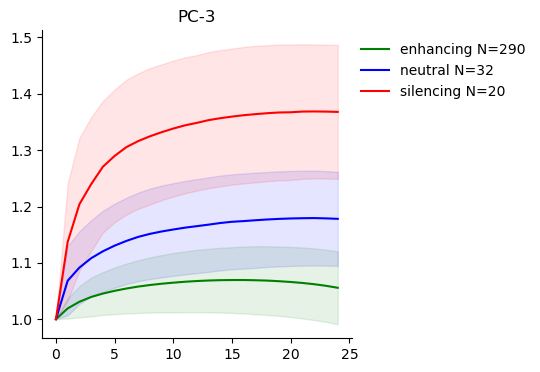

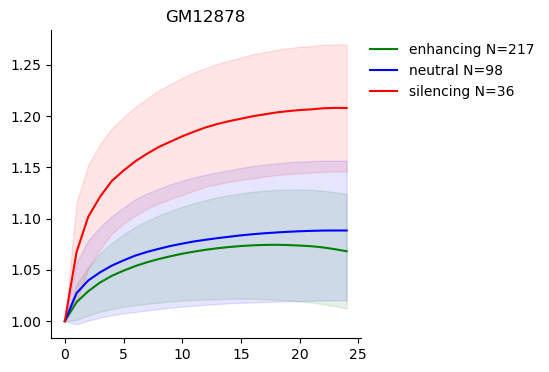

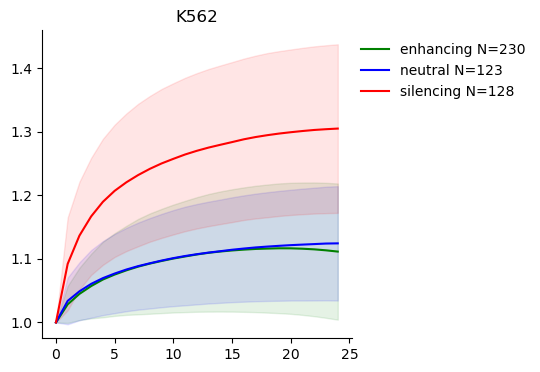

In [14]:
color_map = {'enhancing': 'g', 'neutral':'b', 'silencing':'r'}
for cell_line in cell_lines:


    fig, ax = plt.subplots(1, 1, figsize=[4,4])
    
    for context, data in result_summary[cell_line]['greedy search'].items():
        data = np.array(data)
        
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        color = color_map[context]
        ax.plot(mean, c=color, alpha=1, label=f'{context} N={data.shape[0]}')
        ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)

    plt.legend(frameon=False, bbox_to_anchor=[1.6,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)
    plt.show()

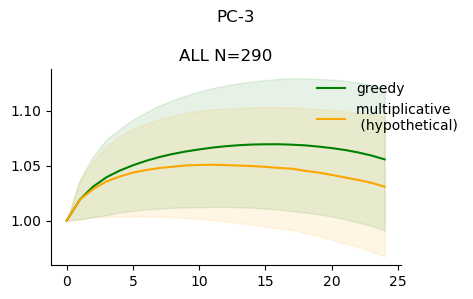

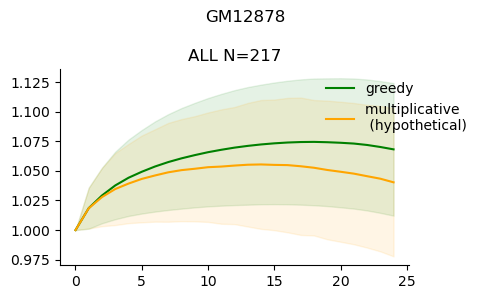

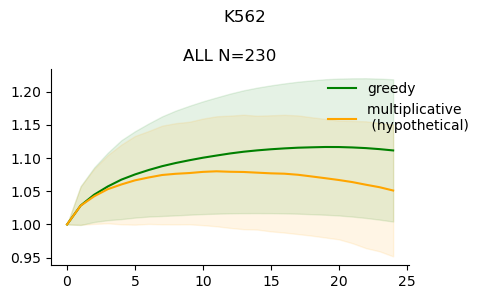

In [15]:
for cell in cell_lines:

    sign = []
    MSE = []
    enhancing_greedy = np.array(result_summary[cell]['greedy search']['enhancing'])
    enhancing_hyp = np.array(result_summary[cell]['hypothetical additive']['enhancing'])
    for trace, hypothetical_trace in zip(enhancing_greedy, enhancing_hyp):
        MSE.append(mean_squared_error(trace, hypothetical_trace))
        sign.append(np.mean(trace) - np.mean(hypothetical_trace))
    MSE = np.array(MSE) 

    colors = ['green', 'orange']
    labels = ['cooperative', 'additive']
    titles = ['ALL']#, 'Enhancer cooperativity', 'Enhancer redundancy', 'Enhancer additivity']
    # i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
    
    pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.1]
    neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.1]
    zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.05]
    all_points = np.arange(len(sign))

    fig, axes = plt.subplots(1, len(titles), figsize=[5, 3])
    curve_labels = ['greedy', 'multiplicative \n (hypothetical)']
    
    for p, points in enumerate([all_points]):#, pos_points, neg_points, zero_points]):
        ax = axes#[p]
        ax.set_title(f'{titles[p]} N={len(points)}')
        trace_set, hypothetical_trace_set = enhancing_greedy[points], enhancing_hyp[points]
        for i, t in enumerate([trace_set, hypothetical_trace_set]):
            
            t_mean = t.mean(axis=0)
            t_std = t.std(axis=0)
            ax.plot(t_mean, color=colors[i], alpha=1, label=curve_labels[i])
        
            ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    ax.legend(frameon=False, bbox_to_anchor=[1.2,1])
    plt.suptitle(cell)
    plt.tight_layout()